In [1]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt

from vgg import VGGNet
from fcn8s import FCN8s
from dataloader import SISSDataset, ToTupleTensor, Rescale, RandomRotate, RandomCrop, Normalize, ToMultiScaleMasks, ToRoIAlignTensor, ToMultiFloatMaskValues
from dataloader import expand_mask

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
from torchvision import transforms, utils, models, datasets
import torch.nn.functional as F
from train import train_model, unmold_mask, resize


In [2]:
vgg_model = VGGNet(freeze_max = False)
net = FCN8s(vgg_model)


In [3]:
all_trainable_layers = [param for param in net.parameters() if param.requires_grad ]


_class    = 2
train_scans = 2
batch_size = 5
epochs     = 10
lr         = 1e-6
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5
configs    = "FCNs-Cross Entropy Loss _batch{}_epoch{}_RMSprop_scheduler-step{}-gamma{}_lr{}_momentum{}_w_decay{}".format(batch_size, epochs, step_size, gamma, lr, momentum, w_decay)
print("Configs:", configs)

class_weights = torch.tensor([0.1, 0.9])
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(all_trainable_layers, lr=lr, weight_decay=w_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # decay LR by a factor of 0.5 every 30 epochs


siss_dataset = SISSDataset(num_slices=154,
                           num_scans=3,
                           root_dir=Path.cwd().parents[0])

idx = 91
sample = siss_dataset[idx]

def show_single_img(image, label):
    """Show image"""
    cmap = 'gray'
    if label:
        cmap = 'binary'
    plt.imshow(image, cmap = cmap)


def viz_sample(sample):
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle('Sample %d' % idx)

    for slice_, scan in enumerate(['dwi', 'flair', 't1', 't2', 'label']):
        ax = plt.subplot(1, 5, slice_ + 1)
        show_single_img(sample[:, :, slice_], scan == 'label')
        plt.tight_layout()
        ax.set_title(scan)
        ax.axis('off')

    plt.show()

# train dataloader
scale = Rescale(int(1.5 * 230))
crop = RandomCrop(224)
rotate = RandomRotate(20.0)
norm = Normalize()
tupled_float_regress_masks = ToMultiFloatMaskValues()

composed = transforms.Compose([scale,
                               rotate,
                               crop,
                               norm,
                               tupled_float_regress_masks])

composed_for_valset = transforms.Compose([
    Rescale(224),
    norm,
    tupled_float_regress_masks
])


siss = SISSDataset(num_slices = 153,
            num_scans= 2,
            root_dir = Path.cwd().parents[0],
            transform = composed_for_valset        
       )

# train dataset
train_dataset = SISSDataset(num_slices = 153,
                            num_scans= train_scans,
                            root_dir = Path.cwd().parents[0],
                            transform = composed)

# val dataset
val_dataset = SISSDataset(num_slices = 153,
                           num_scans= 1,
                           root_dir = Path.cwd().parents[0],
                           transform = composed_for_valset,
                           train = False
                          )

datasets = {
    'train': train_dataset,
    'val': val_dataset
}

# pdb.set_trace()

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
                for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Configs: FCNs-Cross Entropy Loss _batch5_epoch10_RMSprop_scheduler-step50-gamma0.5_lr1e-06_momentum0_w_decay1e-05


In [4]:
def show_single_img(image, label):
    """Show image"""
    cmap = 'gray'
    if label:
        cmap = 'binary'
    plt.imshow(image, cmap = cmap)
    plt.show()


In [5]:

def get_prob_map28(outputs28):
    # based on argmax
    max_prob, pred28_argmax = torch.max(outputs28, dim=1, keepdim=True)  # (batch_size, 1, 28,28)

    # based on prob
    pred28 = outputs28.data
    pred28[:, 0, :, :] = 1 - outputs28[:, 0, :, :]
    one_hot = F.one_hot(pred28_argmax.squeeze()).permute(0, 3, 1, 2).bool()  # (batch_size, 2 classes, 28,28)
    pred28_prob = torch.sum(pred28 * one_hot, dim=1, keepdim=True)  # (batch_size, 1 val, 28, 28)

    return pred28_prob


torch.Size([4, 224, 224]) torch.Size([1, 224, 224]) torch.Size([28, 28])


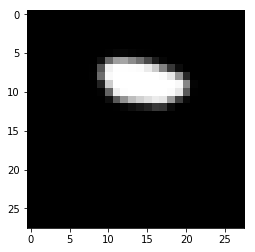

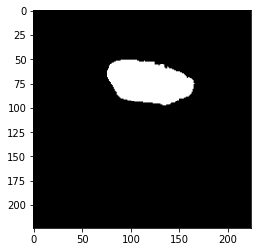

In [6]:
track_sample = siss[91]

scans, label224, label28 = track_sample
print(scans.shape, label224.shape, label28.shape)
print('Image 28 shrinked by bilinear')
show_single_img(label28, label= False)
print('Image 224 shrinked original')
show_single_img(label224[0], label = False)
print('Image 224 expanded from shrinked img28')
show_single_img(expand_mask())

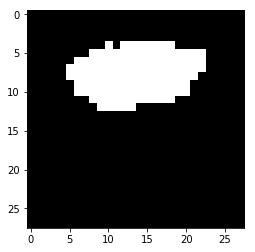

torch.Size([5, 1, 28, 28])


In [25]:
model = net
for mini_batch, (inputs, label224, label28) in enumerate(dataloaders['train']):
    
    outputs28 = model(inputs)  # shape of pred28 is (batch_size, 2, 28, 28)
    
    show_single_img(label28[0,:,:], label=False)
    loss = F.nll_loss(outputs28, label28.squeeze(), weight=class_weights)
    
    torch_pred28_prob = get_prob_map28(outputs28)
    
    print(torch_pred28_prob.shape)
    break